In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.decoding as dec

/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'
# ----------------------------------------

In [4]:
%matplotlib notebook

In [5]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ----------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [6]:
C_value=1.0
test_split=0.2
cv_nfolds=5

chance_level = 1/8. if experiment=='gratings' else 0.5

In [7]:
analysis_type='by_ncells'
test_type='size_single'
class_name = 'morphlevel'
match_rfs = False
overlap_thr= [0, 0.25, 0.5]

test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, '%s' % test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print('making dirs')
print(basedir)


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single


## Output dirs

In [9]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)

curr_dst_dir = os.path.join(basedir, 'controls', 'overlap_thr')

if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES')

['dff-ROC', 'stimulus', 'overlap0.00', 'C1.00']
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/overlap_thr
dff-ROC__stimulus__C1.00


## Check input data

In [16]:
input_id

'dff-ROC__stimulus'

In [27]:
glob.glob(os.path.join(basedir, 'files', 
                                     'inputcells-*_%s__overlap*.pkl' % input_id) )

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/files/inputcells-Li_dff-ROC__stimulus__overlap0.25.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/files/inputcells-Li_dff-ROC__stimulus__overlap0.50.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/files/inputcells-V1_dff-ROC__stimulus__overlap0.50.pkl']

In [23]:
glob.glob(os.path.join(basedir, 'files', 
                                     'inputcells-*'))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/files/inputcells-dff-nstds__plushalf__overlap0.00.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/files/inputcells-dff-nstds__plushalf__matchRF.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/files/inputcells-dff-nstds__stimulus__overlap0.25.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/files/inputcells-dff-nstds__stimulus__overlap0.50.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/files/inputcells-dff-ROC__stimulus__noRF.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/files/inputcells-dff-nstds__plushalf__matchRFoverlap0.00.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/files/inputc

In [28]:
# import _pickle as pkl
# input_id = '__'.join(aggr_id.split('__')[0:-1])
# input_files = glob.glob(os.path.join(basedir, 'files', 
#                                      'inputcells-*_%s__overlap*.pkl' % input_id) )
# #input_files = glob.glob(os.path.join(basedir, 'files', 'inputcells*.pkl'))
# print(len(input_files))
# #input_fpath = input_files[0]
# i_=[]
# for ipath in input_files:
#     with open(ipath, 'rb') as f:
#         icells = pkl.load(f)
    
#     i_.append(icells)
# inputcells = pd.concat(i_, axis=0)

In [11]:
inputcells.columns

NameError: name 'inputcells' is not defined

<IPython.core.display.Javascript object>


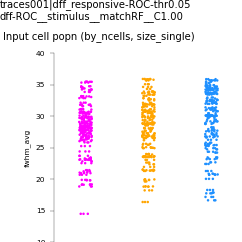

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls input_cell_distribution__dff-ROC__stimulus__matchRF__C1.00


In [11]:
fig, ax = pl.subplots(figsize=(3,3))

sns.stripplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, s=2,
              palette=area_colors, order=visual_areas, zorder=-1000)
# sns.pointplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='k', order=visual_areas, scale=0.5, errwidth=0.5, join=False,
#              markers='_', zorder=1000, ci='sd', estimator=np.median)
ax.set_ylim((10, 40))
pl.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
# sns.boxplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='w', order=visual_areas, fliersize=0)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
fig.text(0.01, 0.85, 'Input cell popn (%s, %s)' % (analysis_type, test_type), 
         fontsize=8)
figname = 'input_cell_distribution__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [29]:
aggr_id

'dff-ROC__stimulus__C1.00'

## Load

In [59]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [60]:
analysis_type

'by_ncells'

In [57]:
iterdf, missing_ = dec.load_iterdf(meta, class_name,
                      experiment=None,
                      analysis_type=analysis_type,
                      test_type=test_type,
                      traceid=traceid,
                      trial_epoch=trial_epoch, responsive_test=responsive_test, 
                      C_value=C_value, break_correlations=False, 
                      match_rfs=False, overlap_thr=overlap_thr)


(Li) Found 9 paths
(Lm) Found 9 paths
(V1) Found 10 paths
    checking for break-corrs
(Li) Found 0 paths
(Lm) Found 0 paths
(V1) Found 0 paths
(Li) Found 7 paths
(Lm) Found 0 paths
(V1) Found 5 paths
    checking for break-corrs
(Li) Found 0 paths
(Lm) Found 0 paths
(V1) Found 0 paths
(Li) Found 6 paths
(Lm) Found 0 paths
(V1) Found 7 paths
    checking for break-corrs
(Li) Found 0 paths
(Lm) Found 0 paths
(V1) Found 0 paths


In [44]:
# sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells\
#                and s!=169]
# iterdf = iterdf[iterdf['n_cells'].isin(sample_sizes)]
# Group means
grouper = ['visual_area', 'condition', 'iteration', 'overlap_thr']
mean_df = dec.average_within_iterations_by_ncells(iterdf, 
                            analysis_type=analysis_type, test_type=test_type,
                            grouper=grouper) 

['visual_area', 'condition', 'iteration', 'overlap_thr', 'n_cells', 'novel']


In [45]:
iterdf.groupby(['visual_area', 'condition', 'overlap_thr', 
                'train_transform', 'test_transform', 'n_cells']).count()

fit_time  \
visual_area condition overlap_thr train_transform test_transform n_cells             
Li          data      0.0         10.0            10.0           1             500   
                                                                 2             500   
                                                                 4             500   
                                                                 8             500   
                                                                 16            500   
...                                                                            ...   
V1          shuffled  0.5         40.0            40.0           2             500   
                                                                 4             500   
                                  50.0            50.0           1             500   
                                                                 2             500   
                                                                 4             500   

                                                                          score_time  \
visual_area condition overlap_thr train_transform test_transform n_cells               
Li          data      0.0         10.0            10.0           1               500   
                                                                 2               500   
                                                                 4               500   
                                                                 8               500   
                                                                 16              500   
...                                                                              ...   
V1          shuffled  0.5         40.0            40.0           2               500   
                                                                 4               500   
                                  50.0            50.0           1               500   
                                                                 2               500   
                                                                 4               500   

                                                                          test_score  \
visual_area condition overlap_thr train_transform test_transform n_cells               
Li          data      0.0         10.0            10.0           1               500   
                                                                 2               500   
                                                                 4               500   
                                                                 8               500   
                                                                 16              500   
...                                                                              ...   
V1          shuffled  0.5         40.0            40.0           2               500   
                                                                 4               500   
                                  50.0            50.0           1               500   
                                                                 2               500   
                                                                 4               500   

                                                                          train_score  \
visual_area condition overlap_thr train_transform test_transform n_cells                
Li          data      0.0         10.0            10.0           1                500   
                                                                 2                500   
                                                                 4                500   
                                                                 8                500   
                                                                 16               500   
...                                       

In [46]:
mean_df.groupby(['visual_area', 'condition', 'novel', 
                  'n_cells', 'overlap_thr',]).count()

iteration  fit_time  \
visual_area condition novel n_cells overlap_thr                        
Li          data      False 1       0.00               500       500   
                                    0.25               500       500   
                                    0.50               500       500   
                            2       0.00               500       500   
                                    0.25               500       500   
...                                                    ...       ...   
V1          shuffled  False 32      0.00               500       500   
                            64      0.00               500       500   
                            96      0.00               500       500   
                            128     0.00               500       500   
                            256     0.00               500       500   

                                                 score_time  test_score  \
visual_area condition novel n_cells overlap_thr                           
Li          data      False 1       0.00                500         500   
                                    0.25                500         500   
                                    0.50                500         500   
                            2       0.00                500         500   
                                    0.25                500         500   
...                                                     ...         ...   
V1          shuffled  False 32      0.00                500         500   
                            64      0.00                500         500   
                            96      0.00                500         500   
                            128     0.00                500         500   
                            256     0.00                500         500   

                                                 train_score  \
visual_area condition novel n_cells overlap_thr                
Li          data      False 1       0.00                 500   
                                    0.25                 500   
                                    0.50                 500   
                            2       0.00                 500   
                                    0.25                 500   
...                                                      ...   
V1          shuffled  False 32      0.00                 500   
                            64      0.00                 500   
                            96      0.00                 500   
                            128     0.00                 500   
                            256     0.00                 500   

                                                 heldout_test_score    C  \
visual_area condition novel n_cells overlap_thr                            
Li          data      False 1       0.00                        500  500   
                                    0.25                        500  500   
                                    0.50                        500  500   
                            2       0.00                        500  500   
                                    0.25                        500  500   
...                                                             ...  ...   
V1          shuffled  False 32      0.00                        500  500   
                            64      0.00                        500  500   
                            96      0.00                        500  500   
                            128     0.00                        500  500   
                            256     0.00                        500  500   

                                                 randi  train_transform  \
visual_area condition novel n_cells overlap_thr                           
Li          data      False 1       0.00           500              500   
                                    0.25           500              500   
              

In [47]:
# max_ncells = 96 # if match_rfs and (responsive_test=='ROC')

In [49]:
n_iters = iterdf['iteration'].max() +1
# xlabels = [1, 32, 64, 96, max_ncells]

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())

mean_df['novel_labels'] = None
mean_df.loc[mean_df['novel'], 'novel_labels'] = 'novel'
mean_df.loc[~mean_df['novel'], 'novel_labels'] = 'trained'

novel: [False  True]
conditions: ['data' 'shuffled']


In [55]:
print_index = ['visual_area','overlap_thr', 'novel']

score_table = mean_df[(mean_df.condition=='data')]\
        .groupby([ 'visual_area', 'n_cells', 'novel', 'overlap_thr'])\
        .mean()['heldout_test_score'].reset_index()\
        .pivot_table(index=print_index, columns='n_cells')

print("EXP: %s (class=%s): %s" % (experiment, class_name, aggr_id))
score_table

EXP: blobs (class=morphlevel): dff-ROC__stimulus__C1.00


heldout_test_score                      \
n_cells                                      1         2         4     
visual_area overlap_thr novel                                          
Li          0.00        False           0.525020  0.544831  0.570656   
                        True            0.523391  0.537498  0.556059   
            0.25        False           0.526037  0.556311  0.581539   
                        True            0.523761  0.542521  0.563620   
            0.50        False           0.541353  0.566203  0.601212   
                        True            0.540802  0.560972  0.593275   
Lm          0.00        False           0.534767  0.545600  0.561500   
                        True            0.517668  0.522439  0.531990   
V1          0.00        False           0.542438  0.560095  0.589200   
                        True            0.520938  0.532741  0.551360   
            0.50        False           0.539905  0.569638  0.595333   
                        True            0.521610  0.540365  0.554051   

                                                                       \
n_cells                             8         16        32        64    
visual_area overlap_thr novel                                           
Li          0.00        False  0.598471  0.615770  0.645717  0.724856   
                        True   0.582581  0.598081  0.623237  0.674318   
            0.25        False  0.615282  0.637539  0.678588  0.755579   
                        True   0.591773  0.613018  0.639431  0.697662   
            0.50        False  0.643491  0.675958  0.722352       NaN   
                        True   0.629424  0.659961  0.693691       NaN   
Lm          0.00        False  0.589667  0.614267  0.640900  0.702533   
                        True   0.541983  0.552917  0.563745  0.595391   
V1          0.00        False  0.619867  0.653233  0.694700  0.768233   
                        True   0.564369  0.583514  0.606193  0.648800   
            0.50        False       NaN       NaN       NaN       NaN   
                        True        NaN       NaN       NaN       NaN   

                                                             
n_cells                             96        128       256  
visual_area overlap_thr novel                                
Li          0.00        False  0.772612  0.808873       NaN  
                        True   0.707698  0.728900       NaN  
            0.25        False       NaN       NaN       NaN  
                        True        NaN       NaN       NaN  
            0.50        False       NaN       NaN       NaN  
                        True        NaN       NaN       NaN  
Lm          0.00        False  0.743033  0.776400       NaN  
                        True   0.614047  0.631041       NaN  
V1          0.00        False  0.815267  0.844700  0.899833  
                        True   0.678997  0.698538  0.737433  
            0.50        False       NaN       NaN       NaN  
                        True        NaN       NaN       NaN

In [19]:
area_colors2 = {'V1': 'darkmagenta', 'Lm': 'saddlebrown', 'Li': 'darkblue'}

In [20]:
pl.rcParams['legend.title_fontsize'] = 8


<IPython.core.display.Javascript object>


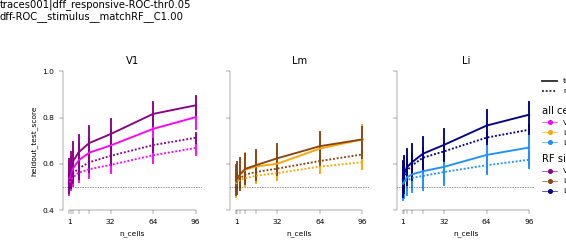

2 [<matplotlib.lines.Line2D object at 0x7f8c93f99ed0>, <matplotlib.lines.Line2D object at 0x7f8c93fa3610>, <matplotlib.lines.Line2D object at 0x7f8c93fa3d10>, <matplotlib.lines.Line2D object at 0x7f8c93fac450>]
1 [<matplotlib.lines.Line2D object at 0x7f8ced1697d0>, <matplotlib.lines.Line2D object at 0x7f8ced169ed0>, <matplotlib.lines.Line2D object at 0x7f8ced16c610>, <matplotlib.lines.Line2D object at 0x7f8ced16cd10>]
2
0 [<matplotlib.lines.Line2D object at 0x7f8c93ecb490>, <matplotlib.lines.Line2D object at 0x7f8c93ecbb90>, <matplotlib.lines.Line2D object at 0x7f8c93ed12d0>, <matplotlib.lines.Line2D object at 0x7f8c93ed19d0>]
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls accuracy_byncell_curves_matchRF-v-all_train-v-novel


In [21]:
metric='heldout_test_score'

plotd = mean_df[mean_df.condition=='data']

#cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
cond_styles = {'trained': '', 'novel': (1,1)}

fig, axn = pl.subplots(1,3, figsize=(7, 3), sharex=True, sharey=True)

for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]; ax.set_title(va);
    sns.lineplot(x='n_cells', y=metric, data=df_[df_.rfs=='all'], ax=ax,
            style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
            color=area_colors[va])
    sns.lineplot(x='n_cells', y=metric, data=df_[df_.rfs=='matched'],ax=ax,
            style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
            color=area_colors2[va])
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.set_ylim([0.4, 1])
    print(ai, ax.legend_.legendHandles)
    if ai==1:
        leg_h = ax.legend_.legendHandles[0:2]
        print(len(leg_h))
        leg = ax.legend(handles=leg_h, bbox_to_anchor=(2.2,1.), loc='upper left', 
                  frameon=False)
        leg._legend_box.align = "left"
    else:
        ax.legend_.remove()
for ax in axn:
    ax.set_yticks(np.linspace(0.4, 1, 4))
    ax.set_ylim([0.4,1])
    ax.set_xticks(sample_sizes)
    ax.set_box_aspect(1)
    ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
sns.despine(trim=True)

leg_h2 = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas], 
                                     labels=visual_areas, markers='.')
leg = axn[-1].legend(handles=leg_h2, bbox_to_anchor=(1,0.8), loc='upper left', 
               frameon=False, title='all cells')
leg._legend_box.align = "left"

leg_h3 = pplot.custom_legend_markers(colors=[area_colors2[v] for v in visual_areas], 
                                     labels=visual_areas, markers='.')
leg = axn[0].legend(handles=leg_h3, bbox_to_anchor=(3.4,0.45), loc='upper left', 
               frameon=False, title='RF size-matched', fontsize=6)
leg._legend_box.align = "left"

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.15, wspace=0.2, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'accuracy_byncell_curves_matchRF-v-all_train-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [22]:
import itertools
max_ncells

96

In [23]:
plotd = mean_df[(mean_df.condition=='data') & (mean_df.n_cells==max_ncells)]
plotd.head()


,visual_area,condition,iteration,n_cells,novel,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,train_transform,test_transform,n_trials,randi_cells,intact,rfs,match_rfs,novel_labels
14,Li,data,0,96,False,0.001201,0.000293,0.740000,1.0,0.825000,1.0,3726.2,30.0,30.0,38.0,2538.0,True,matched,True,trained
15,Li,data,0,96,True,0.001201,0.000293,0.740000,1.0,0.706579,1.0,3726.2,30.0,30.0,38.0,2538.0,True,matched,True,novel
30,Li,data,1,96,False,0.000758,0.000310,0.853333,1.0,0.825000,1.0,4638.4,30.0,30.0,38.0,7280.0,True,matched,True,trained
31,Li,data,1,96,True,0.000758,0.000310,0.853333,1.0,0.751316,1.0,4638.4,30.0,30.0,38.0,7280.0,True,matched,True,novel
46,Li,data,2,96,False,0.000740,0.000296,0.793333,1.0,0.850000,1.0,4090.0,30.0,30.0,38.0,8617.0,True,matched,True,trained


/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


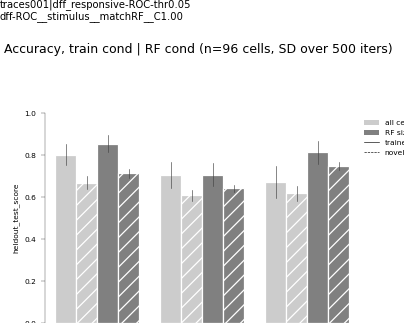

In [24]:
%matplotlib notebook
plotd['plotcond'] = ['%s_%s' %  (r, n) for r, n in plotd[['rfs', 'novel_labels']].values]

matchrf_color = [0.5]*3
all_color = [0.8]*3
plot_palette = {'all_trained': all_color, 'all_novel': all_color,
                'matched_trained': matchrf_color, 'matched_novel': matchrf_color}
keys = ['all_trained', 'all_novel', 'matched_trained', 'matched_novel']

fig, ax = pl.subplots(figsize=(5,4))
sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
           hue='plotcond', hue_order=keys, palette=plot_palette, 
           edgecolor='w', order=visual_areas, ci='sd', errwidth=0.5)
# legends
leg_h = pplot.custom_legend_markers(colors=[all_color, matchrf_color],
                                    labels=['all cells', 'RF size-matched'],
                                    use_patch=True)
leg_h2 = pplot.custom_legend_markers(colors=['k', 'k'],
                                    labels=['trained', 'novel'],markers=None,
                                    linestyles=['-', '--'], use_patch=False)
ax.legend(handles=leg_h+leg_h2, bbox_to_anchor=(0.99,1), 
          loc='upper left', frameon=False)

bar_locs = 3
hatches = itertools.cycle(['', '//'])
for i, bar in enumerate(ax.patches):
    if i % bar_locs == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)
ax.set_aspect(2, anchor='SW')
ax.set_ylim([0, 1])
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8)
fig.text(0.01, 0.85,\
         'Accuracy, train cond | RF cond (n=%i cells, SD over %i iters)' \
         % (max_ncells, n_iters))

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'compare_performance_matchRF-v-all_train-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [30]:
data_df = mean_df[(mean_df.condition=='data') & (mean_df.n_cells==max_ncells)]


In [31]:
data_df.groupby(['visual_area', 'rfs', 'novel']).count()

condition  iteration  n_cells  fit_time  \
visual_area rfs     novel                                            
Li          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   
Lm          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   
V1          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   

                           score_time  test_score  train_score  \
visual_area rfs     novel                                        
Li          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   
Lm          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   
V1          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   

                           heldout_test_score    C  randi  train_transform  \
visual_area rfs     novel                                                    
Li          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   
Lm          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   
V1          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   

                           test_transform  n_trials  randi_cells  intact  \
visual_area rfs     novel                                                  
Li          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              500       500          500     500   
Lm          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              500       500          500     500   
V1          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              50

In [32]:
d_list=[]
for (va, rf_cond), cg in data_df.sort_values(by='iteration')\
                .groupby(['visual_area', 'rfs']):
    novel_scores = cg[cg.novel].sort_values(by='iteration')['heldout_test_score'].values
    trained_scores = cg[~cg.novel].sort_values(by='iteration')['heldout_test_score'].values
    diffs = trained_scores - novel_scores
    df_ = pd.DataFrame({'trained_minus_novel': diffs})
    df_['visual_area'] = va
    df_['condition'] = data_cond
    df_['rfs'] = rf_cond
    df_['iteration'] = cg[cg.novel].sort_values(by='iteration')['iteration'].values
    d_list.append(df_)
diffdf = pd.concat(d_list, axis=0)

<IPython.core.display.Javascript object>


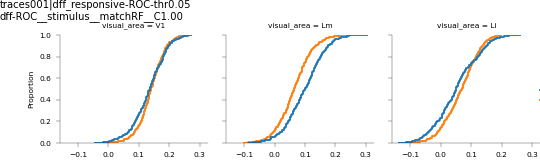

In [33]:
# fig, ax = pl.subplots()
g = sns.displot(hue='rfs', x='trained_minus_novel',  col='visual_area',
           data=diffdf, height=2, col_order=visual_areas, #hue_norm=True,
            kind='ecdf', 
           )
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(g.fig, '%s\n%s' % (data_id, aggr_id))

figname = 'diff_trained-minus-novel_matchrf-v-all'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


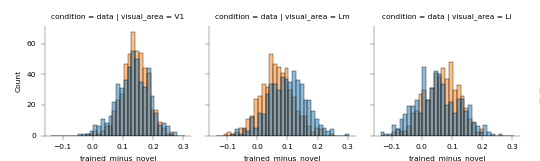

In [34]:
sns.displot(hue='rfs', x='trained_minus_novel',  col='visual_area',
           data=diffdf, height=2, col_order=visual_areas, #hue_norm=True,
            kind='hist', row='condition'
           )

<IPython.core.display.Javascript object>


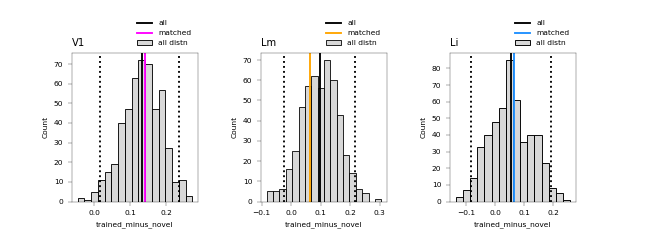

In [50]:
metric='trained_minus_novel'
fig, axn = pl.subplots(1,3, figsize=(8,3))

for va, vg in diffdf.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x=metric, data=vg[vg['rfs']=='all'], ax=ax,
            color=[0.8]*3, label='all distn')
    c_lo, c_hi = hutils.get_empirical_ci(vg[vg['rfs']=='all'][metric].values, ci=0.95)
    ax.axvline(x=c_lo, color='k', ls=':')
    ax.axvline(x=c_hi, color='k', ls=':')
    mean_v0 = vg[vg['rfs']=='all'][metric].mean()
    ax.axvline(x=mean_v0, color='k', label='all')
    
    # sns.histplot(x='trained_minus_novel', data=plotd[plotd['rfs']=='matched'], ax=ax)
    mean_v = vg[vg['rfs']=='matched'][metric].mean()
    ax.axvline(x=mean_v, color=area_colors[va], label='matched')
    ax.set_title(va, loc='left')
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False)
    
pl.subplots_adjust(bottom=0.25, right=0.8, left=0.1, wspace=0.5, top=0.8)

In [51]:
df_ = diffdf[(diffdf['condition']=='data')].copy()
df_.groupby(['visual_area', 'rfs']).count()

trained_minus_novel  condition  iteration
visual_area rfs                                               
Li          all                      500        500        500
            matched                  500        500        500
Lm          all                      500        500        500
            matched                  500        500        500
V1          all                      500        500        500
            matched                  500        500        500

<IPython.core.display.Javascript object>


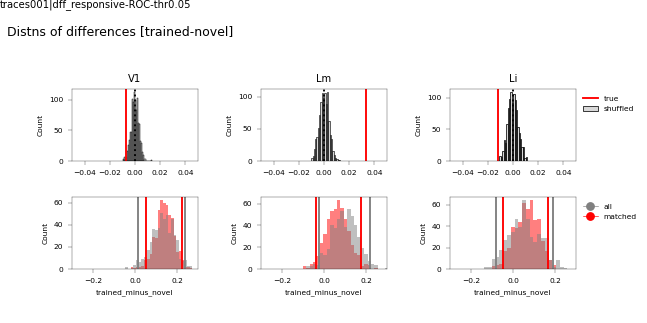

1.0
0.0


No handles with labels found to put in legend.


0.0
1.0
0.985
0.015
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls shuffle_test_DIFF_distn


In [61]:
v1='all'
v2='matched'
c1=[0.5]*3
c2='r'
fig, axn = pl.subplots(2, 3, figsize=(8,4))
for va, vg in diffdf.groupby(['visual_area']):
    # Shuffle test
    a_ = vg[(vg.rfs=='matched')][metric]
    b_ = vg[(vg.rfs=='all')][metric]
    true_ = b_.mean() - a_.mean()
    combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
    shuff_=[]
    for n in range(1000):
        np.random.shuffle(combined_)
        i = np.mean(combined_[0:500])
        v = np.mean(combined_[500:])
        shuff_.append(i-v)
    shuff = np.array(shuff_)

    ai = visual_areas.index(va)
    ax=axn[0, ai]
    sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
    ax.axvline(x=true_, color='r', label='true')
    print(len(np.where(shuff>true_)[0])/1000.)
    print(len(np.where(shuff<true_)[0])/1000.)
    pl.subplots_adjust(bottom=0.2, right=0.8)
    ax.set_xlim([-0.05, 0.05])
    ax.axvline(x=0, color='k', ls=':')

    ax.set_title(va)
    
    # Plot original distns with CI
    ax=axn[1, ai]
    sns.histplot(x=metric, hue='rfs', data=vg, ax=ax,
                palette={v1: c1, v2: c2}, fill=True, edgecolor=None)
    c_lo, c_hi = hutils.get_empirical_ci(vg[vg.rfs==v1][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(vg[(vg.rfs==v2)][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    ax.set_xlim([-0.3, 0.3])
    if ai==2:
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    else:
        ax.legend_.remove()

ax=axn[0, 2]
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax=axn[1,2]
leg_h = pplot.custom_legend_markers(colors=[c1, c2], labels=[v1, v2])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.75, wspace=0.5, hspace=0.5)
fig.text(0.01, 0.9, "Distns of differences [trained-novel]")

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25)

pplot.label_figure(fig, data_id)

figname = 'shuffle_test_DIFF_distn'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


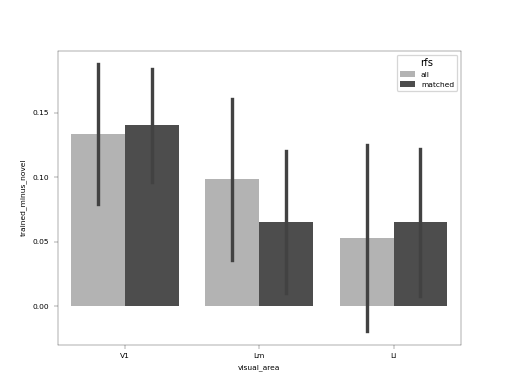

In [70]:
rfmatch_colors={'all': [0.7]*3, 'matched': [0.3]*3}
fig, ax = pl.subplots()

sns.barplot(x='visual_area', y='trained_minus_novel', data=diffdf, ax=ax,
           hue='rfs', palette=rfmatch_colors, order=visual_areas, ci='sd')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2)